In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
from os.path import join as pjoin
import os

In [3]:
import obr
#from functionaries import *
from time_functions import stamp_Ymd
from os_functions import verify_folder_existence
from IPython.display import clear_output

In [4]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'],'size':20})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [5]:
SOURCES_FOLDER = "mcnp_out_medial\\"
#SOURCES_FOLDER = "mcnp_out_20150520\\"
FOLDER_TO_SAVE_IMAGES = pjoin(SOURCES_FOLDER, '__images', stamp_Ymd())
verify_folder_existence(FOLDER_TO_SAVE_IMAGES)

# Энергетические спектры

In [6]:
names_temp = [('NP0a', 'PP0a'),
              ('NP5a',  'PP5a' ),
         ('NP10a', 'PP10a'),
         ('NP15a',  'PP15a' ),
         ('NP20a', 'PP20a'),
         ('NP25a',  'PP25a'),
         ('NP30a',  'PP30a' ),
         ('NP35a',  'PP35a' ),
         ('NP40a', 'PP40a'),
         ('NP45a',  'PP45a' ),
         ('NP50a',  'PP50a' )]
#names = names_temp
names = []
for name in names_temp:
    names.append((pjoin(SOURCES_FOLDER,name[0]), pjoin(SOURCES_FOLDER, name[1])))
names = np.array(names)
names

array([['mcnp_out_medial\\NP0a', 'mcnp_out_medial\\PP0a'],
       ['mcnp_out_medial\\NP5a', 'mcnp_out_medial\\PP5a'],
       ['mcnp_out_medial\\NP10a', 'mcnp_out_medial\\PP10a'],
       ['mcnp_out_medial\\NP15a', 'mcnp_out_medial\\PP15a'],
       ['mcnp_out_medial\\NP20a', 'mcnp_out_medial\\PP20a'],
       ['mcnp_out_medial\\NP25a', 'mcnp_out_medial\\PP25a'],
       ['mcnp_out_medial\\NP30a', 'mcnp_out_medial\\PP30a'],
       ['mcnp_out_medial\\NP35a', 'mcnp_out_medial\\PP35a'],
       ['mcnp_out_medial\\NP40a', 'mcnp_out_medial\\PP40a'],
       ['mcnp_out_medial\\NP45a', 'mcnp_out_medial\\PP45a'],
       ['mcnp_out_medial\\NP50a', 'mcnp_out_medial\\PP50a']], 
      dtype='|S21')

In [7]:
def construct_initial_spectrum_tally(file_, x, y, z):
    tallies = obr.construct_tallies(file_)
    INITIAL_SPECTRUM_TALLY = None
    for tally in tallies:
        if tally.x == x and tally.y == y and tally.z == z:
            INITIAL_SPECTRUM_TALLY = tally
            break
    assert INITIAL_SPECTRUM_TALLY is not None, "No tally with such coordinates."
    return INITIAL_SPECTRUM_TALLY

def sample_length_and_mode_by_file_name(file_name):
    name = os.path.split(file_name)[1]
    if len(name) == 4:
        length = int(name[2:3])
    else:
        length = int(name[2:4])
    return length, name[:2]

def plot_en_spectrums_in_back_going_flow(file_name, tally_distances, colors, file_without_sample, folder_to_place_images):
    tallies = obr.construct_tallies(file_name)
    sample_length, mode = sample_length_and_mode_by_file_name(file_name)
    title = 'back flow spectrum sample len = ' + str(sample_length) + 'cm mode = ' + mode
    outt = open(pjoin(folder_to_place_images,title + ".csv"), 'w')
    outt.write("distance_to_the_tally,E_min,E_max,value,dispersion\n")
    #ax = plt.figure()
    for ind in range(len(tally_distances)):
        tally_distance = tally_distances[ind]
        col = colors[ind]
        import matplotlib.pyplot as plt
        left = []
        width = []
        values = []
        dy = []
        mid = []
        x = 0
        y = 0
        z = 100 - tally_distance - 1.5 - sample_length
        print 'z = ',z
        if mode == 'PP':
            etalon = construct_initial_spectrum_tally(file_without_sample, x, y, 100 - 5 - 1.5)
        count_tallies = 0
        for tally in tallies:
            if tally.x == x and tally.y == y and tally.z == z:
                count_tallies += 1
                kk = tally.values.keys()
                kk.sort()
                kk = sorted(kk)
                #print [x[0] for x in kk]
                for en_diap in kk:
                    outt.write(str(tally_distance) + ',' + str(en_diap[0]) + ',' + str(en_diap[1]) + ',' + str(tally.values[en_diap]) + ',' + str(tally.dispersion[en_diap]) + '\n')
                    if en_diap[0] > 7:
                        continue
                    if mode == 'PP':
                        if en_diap[0] > 1:
                            continue
                    left.append(en_diap[0])
                    width.append(en_diap[1] - en_diap[0])
                    if mode == 'PP':
                        values.append((tally.values[en_diap] - etalon.values[en_diap]) * (en_diap[1] - en_diap[0]) / 4)
                    else:
                        values.append(tally.values[en_diap] * (en_diap[1] - en_diap[0]))
                    dy.append(tally.dispersion[en_diap]*values[-1]  * (en_diap[1] - en_diap[0]))
                    mid.append((en_diap[1] + en_diap[0])/2)
        if count_tallies == 0:
            print "Warning! No tallies for distance {len} found".format(len=tally_distance)
        plt.bar(left, values,width, color=col, yerr=dy, log=True, bottom=0.000000001, label=('distance to detector = ' + str(tally_distance) + 'cm.'))
        #plt.errorbar(left, values, color=col, yerr=dy, label=('distance to detector = ' + str(tally_distance) + 'cm.'))
        #plt.yscale('log')
        #plt.ylim([10**(-11),10**(-6)])
        plt.title(r'back flow.spectrum.\\sample len = ' + str(sample_length) + r'cm. mode = ' + mode)
        plt.xlabel(r'Energy, MEV')
        plt.ylabel(r'particles, $\bf \frac{F}{cm^2 sec}$')

    outt.close()
    plt.legend(loc='best',prop={'size':12})
    plt.grid()
    #plt.xscale('log')
    plt.gcf().subplots_adjust(bottom=0.2, top=0.8, left=0.2)
    plt.savefig(pjoin(folder_to_place_images,title.replace(' ','_') + ".png"), dpi = 300)
    print pjoin(folder_to_place_images,title.replace(' ','_') + ".png")
    plt.show()
    plt.close()
    return left, values, width

def plot_sum_en_spectrum_in_back_going_flow(file_names, tally_distances, colors, PP_file_without_sample, folder_to_place_images):
    neutron_file, photon_file = file_names
    if os.path.split(neutron_file)[1][1:] != os.path.split(photon_file)[1][1:]:
        print "files_not_correspond_to_each_other"
        return
    tallies_n, tallies_p = obr.construct_tallies(neutron_file), obr.construct_tallies(photon_file)
    sample_length, garbage = sample_length_and_mode_by_file_name(file_names[0])
    title = 'back flow spectrum sample len = ' + str(sample_length) + 'cm mode = full'
    outt = open(pjoin(folder_to_place_images, title + ".csv"), 'w')
    outt.write("distance_to_the_tally,E_min,E_max,value,dispersion\n")
    for ind in range(len(tally_distances)):
        tally_distance = tally_distances[ind]
        col = colors[ind]
        import matplotlib.pyplot as plt
        left = []
        width = []
        values = []
        dy = []
        mid = []
        x = 0
        y = 0
        z = 100 - tally_distance - 1.5 - sample_length
        etalon = construct_initial_spectrum_tally(PP_file_without_sample,x,y,z = 100 - 5 - 1.5)
        for tally_ind, tally in enumerate(tallies_n):
            if tallies_n[tally_ind].x == x and tallies_n[tally_ind].y == y and tallies_n[tally_ind].z == z:
                if tallies_p[tally_ind].x != x or tallies_p[tally_ind].y != y or tallies_p[tally_ind].z != z:
                    print "wrong tallies order"
                    return
                kk = tallies_n[tally_ind].values.keys()
                kk.sort()
                for en_diap in kk:
                    outt.write(str(tally_distance) + ',' + str(en_diap[0]) + ',' + str(en_diap[1]) + ',' + str(tally.values[en_diap]) + ',' + str(tally.dispersion[en_diap]) + '\n')
                    if en_diap[0] > 7:
                        continue

                    left.append(en_diap[0])
                    width.append(en_diap[1] - en_diap[0])
                    values.append((tallies_n[tally_ind].values[en_diap] +
                                       (tallies_p[tally_ind].values[en_diap] - etalon.values[en_diap])/4)
                                        * (en_diap[1] - en_diap[0]))
                    temp = (tallies_n[tally_ind].dispersion[en_diap]*tallies_n[tally_ind].values[en_diap] + tallies_p[tally_ind].dispersion[en_diap]*(tallies_p[tally_ind].values[en_diap] - etalon.values[en_diap])/4 ) * (en_diap[1] - en_diap[0])
                    dy.append(min(temp, values[-1]))
                    mid.append((en_diap[1] + en_diap[0])/2)
        plt.bar(left, values,width, color=col, yerr=dy, log=True, bottom=0.000000001, label=('distance to detector = ' + str(tally_distance) + 'cm.'))
        #plt.errorbar(left, values, color=col, yerr=dy, label=('distance to detector = ' + str(tally_distance) + 'cm.'))
        #plt.yscale('log')
        #plt.ylim([10**(-11),10**(-6)])
        plt.title(r'back flow.spectrum.\\sample len = ' + str(sample_length) + r'cm. mode = full')
        plt.xlabel(r'Energy, MEV')
        plt.ylabel(r'particles, $\bf \frac{F}{cm^2 sec}$')
        #plt.plot(mid, y, 'r--')
        #plt.savefig("images\\" + title + ".png", dpi = 300)
        #plt.show()
        #plt.close()
    outt.close()
    plt.legend(loc='best',prop={'size':12})
    plt.grid()
    plt.gcf().subplots_adjust(bottom=0.2, top=0.8, left=0.2)
    plt.savefig(pjoin(folder_to_place_images, title.replace(' ','_') + ".png"), dpi = 300)
    print pjoin(folder_to_place_images, title.replace(' ','_') + ".png")
    plt.show()
    plt.close()
    return left, values, width


z =  93.5
z =  88.5
z =  78.5
z =  43.5
mcnp_out_medial\__images\20150614\back_flow_spectrum_sample_len_=_5cm_mode_=_NP.png


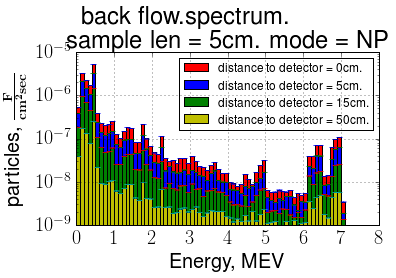

z =  93.5
z =  88.5
z =  78.5
z =  43.5
mcnp_out_medial\__images\20150614\back_flow_spectrum_sample_len_=_5cm_mode_=_PP.png


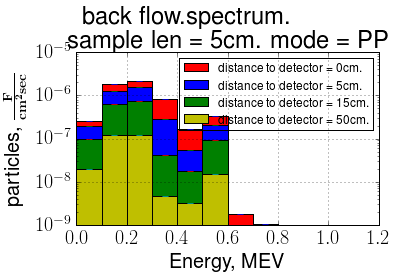

mcnp_out_medial\__images\20150614\back_flow_spectrum_sample_len_=_5cm_mode_=_full.png


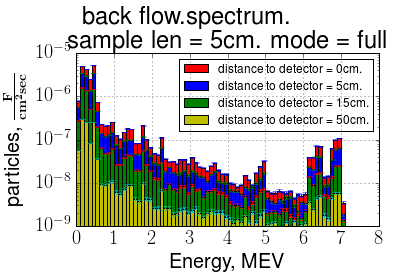

z =  48.5
z =  43.5
z =  33.5
z =  -1.5
mcnp_out_medial\__images\20150614\back_flow_spectrum_sample_len_=_50cm_mode_=_NP.png


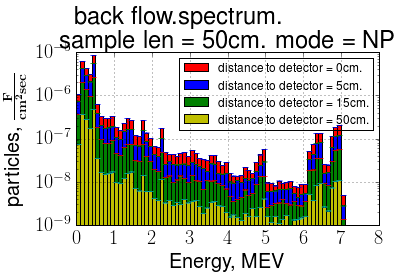

z =  48.5
z =  43.5
z =  33.5
z =  -1.5
mcnp_out_medial\__images\20150614\back_flow_spectrum_sample_len_=_50cm_mode_=_PP.png


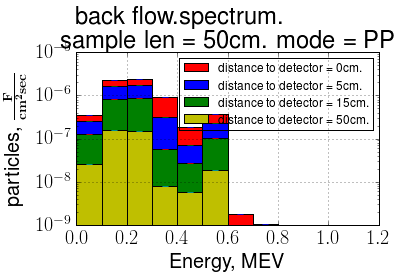

mcnp_out_medial\__images\20150614\back_flow_spectrum_sample_len_=_50cm_mode_=_full.png


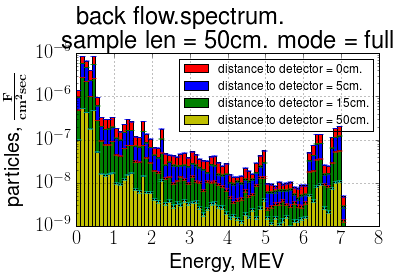

In [31]:
for name in names[[1,10]]:
    plot_en_spectrums_in_back_going_flow(name[0],[0,5,15,50], ['red','blue','green','y'],pjoin(SOURCES_FOLDER, 'PP0a'),FOLDER_TO_SAVE_IMAGES)
    plot_en_spectrums_in_back_going_flow(name[1],[0,5,15,50], ['red','blue','green','y'],pjoin(SOURCES_FOLDER, 'PP0a'),FOLDER_TO_SAVE_IMAGES)
    plot_sum_en_spectrum_in_back_going_flow(name,[0,5,15,50], ['red','blue','green','y'],pjoin(SOURCES_FOLDER, 'PP0a'),FOLDER_TO_SAVE_IMAGES)
    #clear_output(wait=True)

# Доза излучения в обратном потоке

### Доза чистого источника.

In [9]:
for tally in  obr.construct_tallies(names[0][1]):
    if (tally.x == 0) and (tally.y == 0):
        print tally.get_dose()
        print tally.get_dose()*5./4.
        print tally.get_dose()*1./4.  
        break

[  8.56103780e-07   5.05211639e-09]
[  1.07012972e-06   6.31514549e-09]
[  2.14025945e-07   1.26302910e-09]


In [105]:
FIGURES_SIZE = (6,4)
LEGENDS_SIZE = 12

def sample_length_and_mode_by_file_name(file_name):
    name = os.path.split(file_name)[1]
    if len(name) == 4:
        length = int(name[2:3])
    else:
        length = int(name[2:4])
    return length, name[:2]


def plot_dose_in_back_going_flow_for_each_file(names, tally_distanses, file_without_sample, folder_to_place_images):
    plt.figure(figsize=FIGURES_SIZE)
    legend = []
    for file_name in names:
        sample_length, mode = sample_length_and_mode_by_file_name(file_name)
        #print sample_length
        tallies = obr.construct_tallies(file_name)
        dosa_at_length = {}
        for tally_ind, tally in enumerate(tallies):
            if tally.x == 0 and tally.y == 0 and (100 - tally.z - 1.5 - sample_length in tally_distanses):
                #print tally.x, tally.y, tally.z
                etalon = construct_initial_spectrum_tally(file_without_sample,
                                                          tally.x,
                                                          tally.y,
                                                          tally.z + sample_length - 5)
                dosa, dispersion = (tally.get_dose() - etalon.get_dose())
                if mode == 'PP':
                    dosa = dosa/4.
                dosa_at_length[100 - tally.z - 1.5 - sample_length] = (dosa, dispersion)
                #print (dosa, dispersion)
        x = sorted(dosa_at_length.keys())
        y = [dosa_at_length[k][0] for k in x]
        dy = [dosa_at_length[k][0]*dosa_at_length[k][1] for k in x]
        plt.yscale('log')
        plt.errorbar(x,y,yerr=dy)
        plt.xlabel('Distance to detector, sm.')
        plt.ylabel(r'Dose $\bf \frac{mkr}{sec}$')
        plt.grid('on')
        legend.append("Sample length = " + str(sample_length))
    title = "Dose in back going flow mode = " + mode
    plt.title(title)
    plt.legend(legend, loc='best', prop={'size':LEGENDS_SIZE})
    plt.gcf().subplots_adjust(bottom=0.2, top=0.8, left=0.2)
    plt.savefig(pjoin(folder_to_place_images,title.replace(' ','_') + ".png"), dpi = 300)
    plt.show()

def plot_full_dose_in_back_going_flow_for_each_file(names, tally_distanses, files_without_sample, folder_to_place_images):
    plt.figure(figsize=FIGURES_SIZE)
    legend = []
    etalon_n_file, etalon_p_file = files_without_sample
    for neutron_file, photon_file in names:
        sample_length, garbage = sample_length_and_mode_by_file_name(neutron_file)
        tallies_n, tallies_p = obr.construct_tallies(neutron_file), obr.construct_tallies(photon_file)
        dosa_at_length = {}
        for tally_ind, (tally_n, tally_p) in enumerate(zip(tallies_n, tallies_p)):
            if tally_n.x == 0 and tally_n.y == 0 and (100 - tally_n.z - 1.5 - sample_length in tally_distanses):
                #print tally_n.x, tally_n.y, tally_n.z
                etalon_n = construct_initial_spectrum_tally(etalon_n_file,
                                                              tally_p.x,
                                                              tally_p.y,
                                                              tally_p.z + sample_length - 5)
                etalon_p = construct_initial_spectrum_tally(etalon_p_file,
                                                              tally_p.x,
                                                              tally_p.y,
                                                              tally_p.z + sample_length - 5)
                dosa, dispersion = tally_n.get_dose() - etalon_n.get_dose() + (tally_p.get_dose() - etalon_p.get_dose())/4.
                dosa_at_length[100 - tally_n.z - 1.5 - sample_length] = (dosa, dispersion)
        x = sorted(dosa_at_length.keys())
        y = [dosa_at_length[k][0] for k in x]
        dy = [dosa_at_length[k][0]*dosa_at_length[k][1] for k in x]
        plt.yscale('log')
        plt.errorbar(x,y,yerr=dy)
        plt.xlabel('Distance to detector, sm.')
        plt.ylabel(r'Dose $\bf \frac{mkr}{sec}$')
        plt.grid('on')
        legend.append("Sample length = " + str(sample_length))
    title = "Dose in back going flow mode = full"
    plt.title(title)
    plt.legend(legend, loc='best', prop={'size':LEGENDS_SIZE})
    plt.gcf().subplots_adjust(bottom=0.2, top=0.8, left=0.2)
    plt.savefig(pjoin(folder_to_place_images,title.replace(' ','_') + ".png"), dpi = 300)
    plt.show()


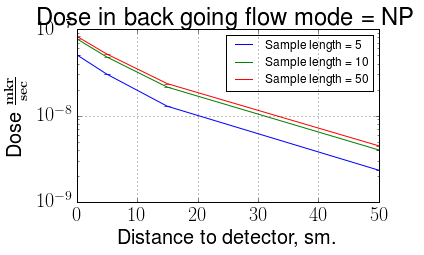

In [106]:
plot_dose_in_back_going_flow_for_each_file(names[:,0][[1,2,10]], [0,5,15,50], pjoin(SOURCES_FOLDER, 'NP0a'), FOLDER_TO_SAVE_IMAGES)

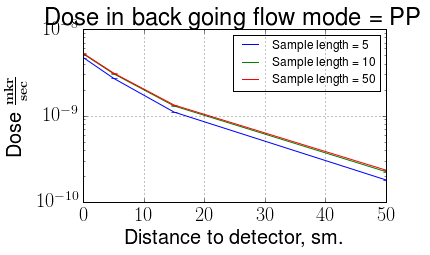

In [107]:
plot_dose_in_back_going_flow_for_each_file(names[:,1][[1,2,10]], [0,5,15,50], pjoin(SOURCES_FOLDER, 'PP0a'), FOLDER_TO_SAVE_IMAGES)

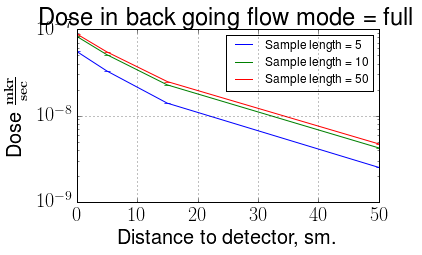

In [108]:
plot_full_dose_in_back_going_flow_for_each_file(names[[1,2,10]], [0,5,15,50], (pjoin(SOURCES_FOLDER, 'NP0a'), pjoin(SOURCES_FOLDER, 'PP0a')), FOLDER_TO_SAVE_IMAGES)

# Доза излучения за образцом.

In [31]:
from functionaries import sample_length_and_mode_by_file_name
from functionaries import extend_x_y, griddata_sc, itertools

FIGURES_SIZE = (6,4)
def plot_dose_after_the_sample(names, FOLDER_TO_SAVE_IMAGES, subpl=None, interp_method='linear'):
    counter = 1
    if subpl is not None:
        plt.figure(figsize=(FIGURES_SIZE[0]*subpl[1], FIGURES_SIZE[0]*subpl[0]))
    
    for neutron_file, photon_file in names:
        if subpl is not None:
            plt.subplot(subpl[0], subpl[1], counter)
        else:
            plt.figure(figsize=FIGURES_SIZE)
        counter += 1
        sample_length, garbage = sample_length_and_mode_by_file_name(neutron_file)
        tallies_n, tallies_p = obr.construct_tallies(neutron_file), obr.construct_tallies(photon_file)
        xs = []
        ys = []
        doses = []
        for tally_n, tally_p in zip(tallies_n, tallies_p):
            assert tally_n.is_the_same(tally_p), "Tallies are not correspond to each other."
            if abs(tally_n.x) > 20 or abs(tally_n.y) > 20 or tally_n.z < 100:
                continue
            dose = tally_n.get_dose()[0] + tally_p.get_dose()[0]/4.
            for x,y in extend_x_y(tally_n.x,tally_n.y):
                xs.append(x)
                ys.append(y)
                doses.append(dose)
        xis = np.linspace(-20,20,100)
        yis = np.linspace(-20,20,100)
        #zis = griddata(xs,ys,doses,xis,yis,interp='linear')
        #zis = griddata(xs,ys,doses,xis,yis,interp='nn')
        zis = griddata_sc(np.array(list(zip(xs, ys))), np.array(doses), np.array(list(itertools.product(xis, yis))),  method=interp_method, fill_value=0).reshape((100,100))
        CS = plt.contour(xis, yis, zis, 5, linewidths=0.5, colors='b')
        CS = plt.contourf(xis, yis, zis, 5, cmap=plt.cm.rainbow,
                  vmax=abs(zis).max(), vmin=-abs(zis).max())
        cbar = plt.colorbar()

        plt.scatter(xs,ys,c=doses, cmap=plt.cm.rainbow, vmax=abs(zis).max(), vmin=-abs(zis).max())#, s=norm(doses)*30000)
        plt.xlim(-21,21)
        plt.ylim(-21,21)
        cbar.set_label(r'$\frac{mkr}{sec}$')
        title = "Dose after the sample.\n sample length = " + str(sample_length) + '. m = full'
        plt.title(title)
        plt.xlabel("'x' dimension, sm")
        plt.ylabel("'y' dimension, sm")
        if subpl is None:
            plt.gcf().subplots_adjust(bottom=0.2, top=0.8, left=0.2)
            plt.savefig(pjoin(FOLDER_TO_SAVE_IMAGES, title.replace('\n','_') + '.png'), dpi=300)
            plt.show()

    if subpl is not None:

        plt.savefig(pjoin(FOLDER_TO_SAVE_IMAGES, 'Doses_after_the_sample.' + '.png'), dpi=300)

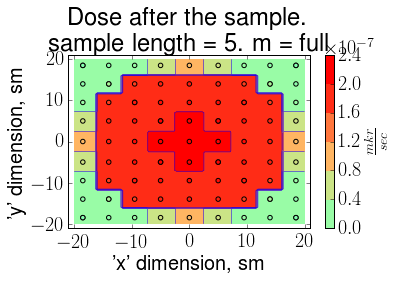

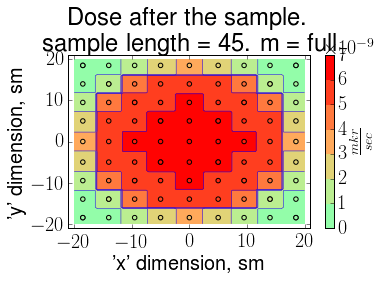

In [32]:
plot_dose_after_the_sample(names[[1,9]], FOLDER_TO_SAVE_IMAGES, interp_method='nearest')

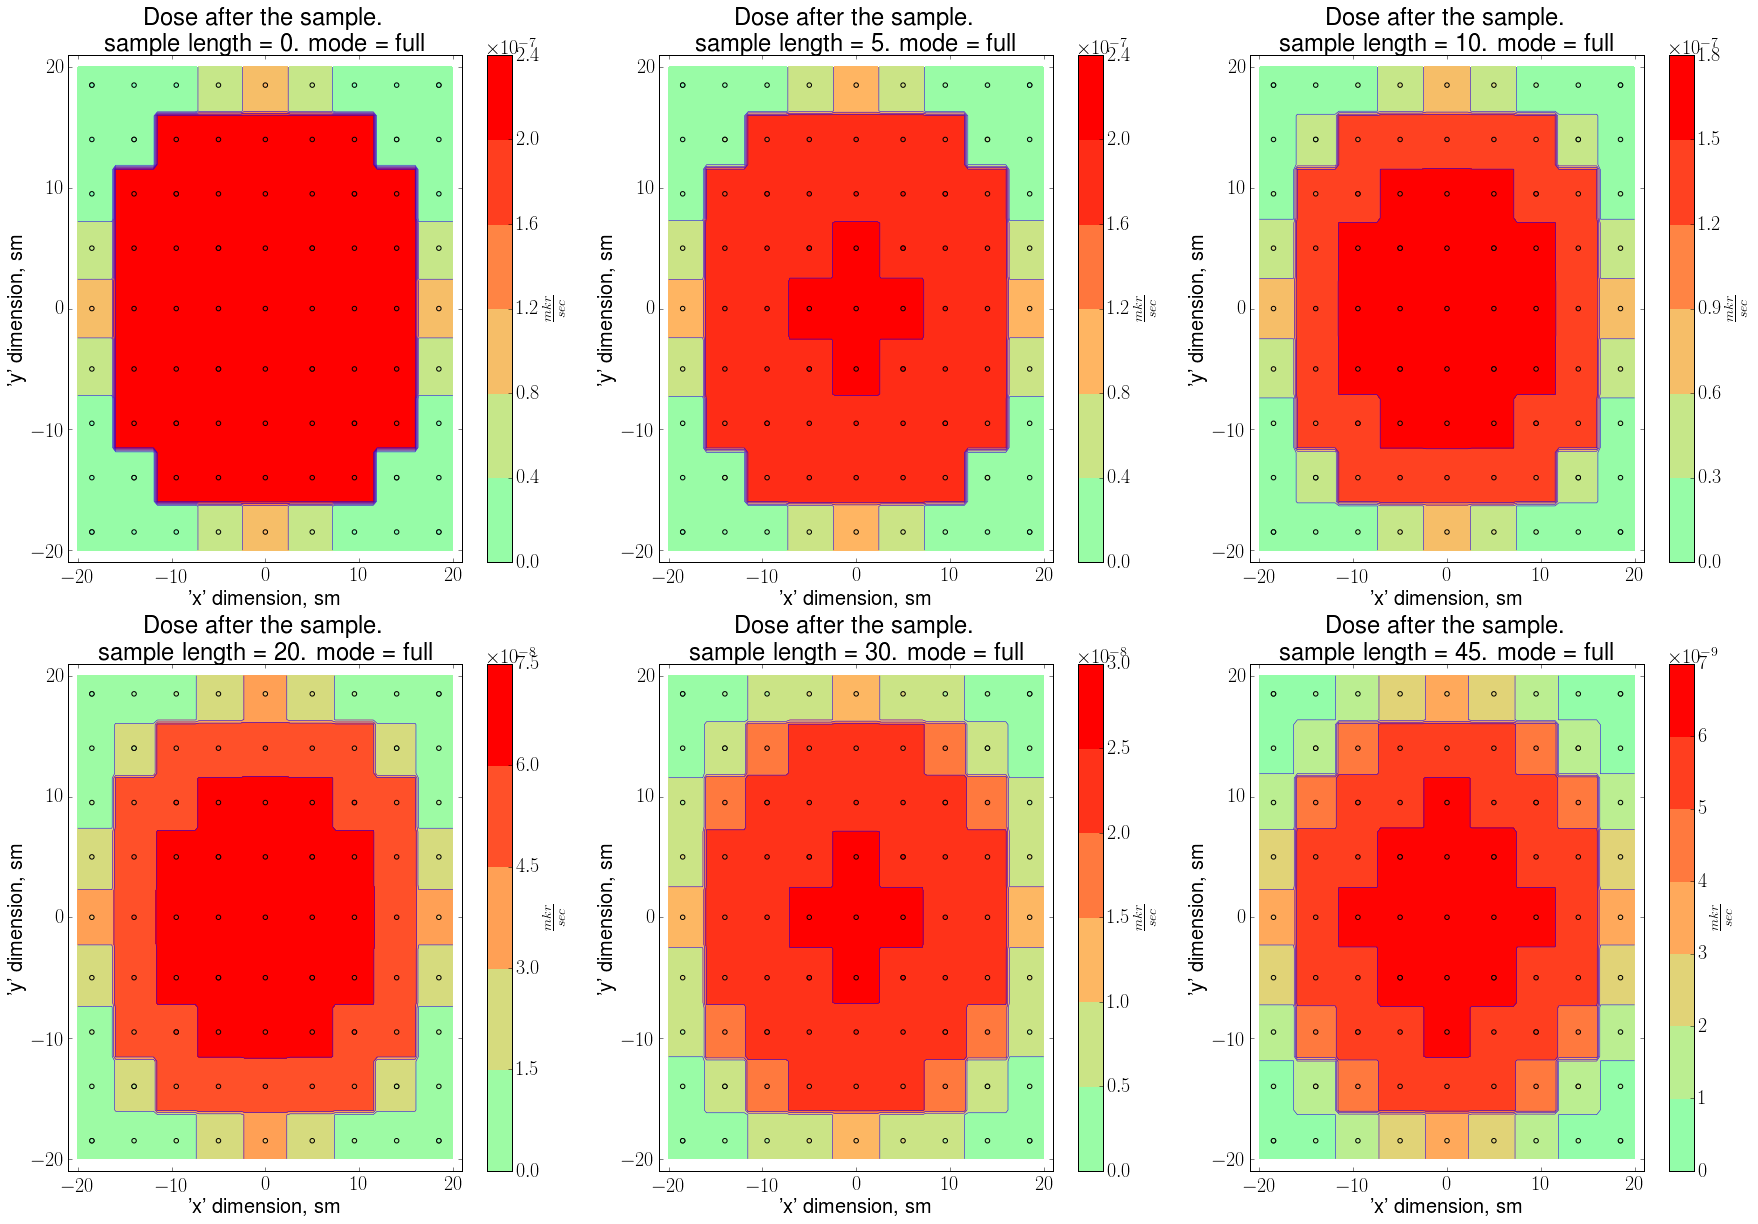

In [130]:
plot_dose_after_the_sample(names[[0,1,2,4,6,9]], FOLDER_TO_SAVE_IMAGES, subpl=(2,3), interp_method='nearest')

In [109]:
figures_size = (10,6)
class Colors_generator:
    def __init__(self):
        self.colors = ['blue','green','red','black','yellow','cyan','magenta']
        self.i = -1
        
    def current(self):
        return self.colors[self.i]
    
    def get_next(self):
        self.i = (self.i + 1)%len(self.colors)
        return self.current()

In [116]:
def sample_length_and_mode_by_file_name(file_name):
    name = os.path.split(file_name)[1]
    if len(name) == 4:
        length = int(name[2:3])
    else:
        length = int(name[2:4])
    return length, name[:2]

class PlotSmthAfterTheSampleCommon(object):
#class PlotSmthAfterTheSampleCommon:
    def __init__(self, file_name):
        if isinstance(file_name, list) or isinstance(file_name, tuple) or isinstance(file_name, np.ndarray):
            self.mode = 'full'
            assert len(file_name) == 2, "Should be photon and neutron files."
            self.neutron_file = file_name[0]
            self.photon_file = file_name[1]
            n_name = os.path.split(self.neutron_file)[1]
            n_l, n_type = sample_length_and_mode_by_file_name(n_name)
            p_name = os.path.split(self.photon_file)[1]
            p_l, p_type = sample_length_and_mode_by_file_name(p_name)
            assert n_type == 'NP', 'Firsts should be a neutron file'
            assert p_type == 'PP', 'Seconds should be a photon file'
            assert n_l == p_l, "Files should be the same length."
            self.length = n_l
        else:
            self.file_name = file_name
            self.length, self.mode = sample_length_and_mode_by_file_name(os.path.split(self.file_name)[1])
            
    
    #def get_values(self):
    #    raise NotImplementedError
    
    def plot(self, title_preffix, color='blue', y_label = r'particles, $\frac{F}{cm^2 sec}$'):
        self.title_preffix = title_preffix
        x, y, dy = self.get_values()
        plt.errorbar(x, y, color=color, yerr=dy, label=(str(self.length) ) + ' sm', fmt='-o')
        plt.title(self.title_preffix + r'  . mode = ' + self.mode)
        plt.xlabel(r'length, cm')
        plt.ylabel(y_label)
        return self.mode
        
class PlotDoseAfterTheSampleCommon(PlotSmthAfterTheSampleCommon):
    def get_values(self):
        if self.mode == 'full':
            tallies_n = obr.construct_tallies(self.neutron_file)
            tallies_p = obr.construct_tallies(self.photon_file)
            assert len(tallies_n) == len(tallies_p), "Files have different geometries."
            x = []
            y = []
            dy = []
            for i in range(len(tallies_n)):
                tally_n = tallies_n[i]
                tally_p = tallies_p[i]
                assert (tally_n.x == tally_p.x) and (tally_n.y == tally_p.y) and (tally_n.z == tally_p.z), "Files have different geometries."
                if (tally_n.z > 100) and (abs(tally_n.x) == abs(tally_n.y)):
                    x_ = 2**(1./2)*tally_n.x
                    yn, dyn = tally_n.get_dose()
                    yp, dyp = tally_p.get_dose()
                    y.append(yn + yp/4)
                    x.append(x_)
                    dy.append(dyn+dyp)
            x = np.array(x)
            y = np.array(y)
            dy = np.array(dy)
            sorting_indexes = np.argsort(x)
            x = x[sorting_indexes]
            y = y[sorting_indexes]
            dy = dy[sorting_indexes]
            return x, y, dy
        else:
            tallies = obr.construct_tallies(self.file_name)
            x = []
            y = []
            dy = []
            for tally in tallies:
                if self.mode == 'PP':
                    mult = 1./4
                else:
                    mult = 1
                if (tally.z > 100) and (abs(tally.x) == abs(tally.y)):
                    x_ = 2**(1./2)*tally.x
                    y_, dy_ = tally.get_dose()
                    y.append(y_*mult)
                    x.append(x_)
                    dy.append(dy_*mult)
            return np.array(x), np.array(y), np.array(dy)
        
        
            
def plot_doses_after_sample(names, indexes):
    c_generator = Colors_generator()
    plt.figure(figsize=FIGURES_SIZE)
    for i in indexes:
        mode = PlotDoseAfterTheSampleCommon(names[i]).plot('dose',
                                                    color=c_generator.get_next(),
                                                    y_label = r'dose, $\bf \frac{mkr}{sec}$')
    plt.yscale('log')
    plt.grid()
    plt.legend(loc='best', prop={'size':LEGENDS_SIZE})
    plt.gcf().subplots_adjust(bottom=0.2, top=0.8, left=0.2)
    plt.savefig(pjoin(FOLDER_TO_SAVE_IMAGES, 'dose_after_the_sample_common_style_' + mode + '.png'), dpi=300)
    plt.show()

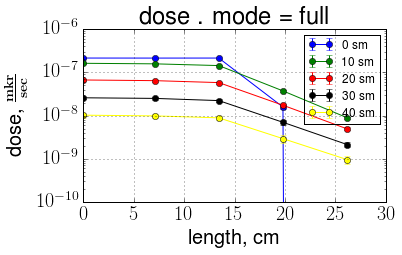

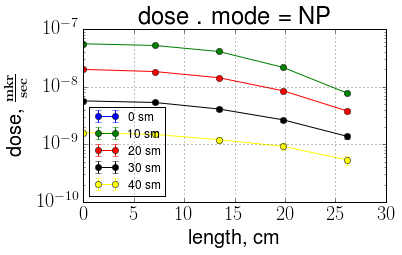

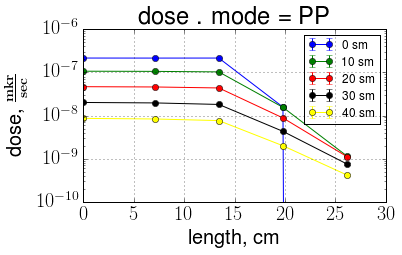

In [117]:
indexes = list(range(0,9,2))
plot_doses_after_sample(names, indexes)
plot_doses_after_sample(names[:,0], indexes)
plot_doses_after_sample(names[:,1], indexes)

# Стенка

In [120]:
def __parse_name(file_name):
    ans = {}
    name = os.path.split(file_name)[1]
    ans['mode'] = name[:2]
    ans['is_carbon'] = name.find('C') != -1
    if ans['is_carbon']:
        ans['length'] = int(name[3:-1])
    else:
        ans['length'] = int(name[2:-1])
    return ans

def parse_file_name(file_name, what_to_return):
    ans = []
    p = __parse_name(file_name)
    for ret in what_to_return:
        ans.append(p[ret])
    return ans

    
def plot_dose_on_wall(files_names):
    #print files_names
    colors = Colors_generator()
    plt.figure(figsize=FIGURES_SIZE)
    names = [os.path.split(x)[1] for x in files_names]
    prefixes = [x[:2] for x in names]
    assert len(set(prefixes)) == 1, "Files are in differend modes."
    mode = prefixes[0]
    ys = []
    for file_ in files_names:
        #print file_
        length = parse_file_name(file_, ['length'])[0]
        tallies = obr.construct_tallies(file_)
        x = []
        y = []
        for tally in tallies:
            if tally.x == 0 and tally.y < -97:
                x.append(tally.z)
                y.append(tally.get_dose()[0])
        x = np.array(x)
        y = np.array(y)
        indexes = np.argsort(x)
        x = x[indexes]
        y = y[indexes]
        #print x
        #print y
        if mode == 'PP':
            y = y/4.
        ys.append(y)
        plt.plot(x,y,marker='o', label=str(length), c=colors.get_next())
        plt.plot([100 - length,100 - length],[np.min(y),np.max(y)], '-.',c=colors.current(), linewidth=3)
        #break
    plt.plot([100,100],[np.min(ys),np.max(ys)], '--', c='blue')
    plt.legend(loc = 'best')
    plt.title('wall ' + mode)
    plt.savefig(pjoin(FOLDER_TO_SAVE_IMAGES, 'wall ' + mode + '.png'))
    
def plot_full_dose_on_wall(files_names):
    #print files_names
    colors = Colors_generator()
    plt.figure(figsize=FIGURES_SIZE)
    mode = 'full'
    ys = []
    for file_p, file_n in files_names:
        #print file_
        length = parse_file_name(file_n, ['length'])[0]
        tallies_n = obr.construct_tallies(file_n)
        tallies_p = obr.construct_tallies(file_p)
        x = []
        y = []
        for i in range(len(tallies_n)):
            if tallies_n[i].x == 0 and tallies_n[i].y < -97:
                x.append(tallies_n[i].z)
                y.append(tallies_n[i].get_dose()[0] + tallies_p[i].get_dose()[0]/4)
        x = np.array(x)
        y = np.array(y)
        indexes = np.argsort(x)
        x = x[indexes]
        y = y[indexes]
        #print x
        #print y
        ys.append(y)
        plt.plot(x,y,marker='o', label=str(length), c=colors.get_next())
        plt.plot([100 - length,100 - length],[np.min(y),np.max(y)], '-.',c=colors.current(), linewidth=3)
        #break
    plt.plot([100,100],[np.min(ys),np.max(ys)], '--', c='blue')
    plt.legend(loc = 'best')
    plt.title('wall ' + mode)
    plt.savefig(pjoin(FOLDER_TO_SAVE_IMAGES, 'wall ' + mode + '.png'))

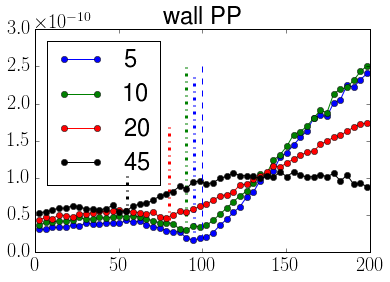

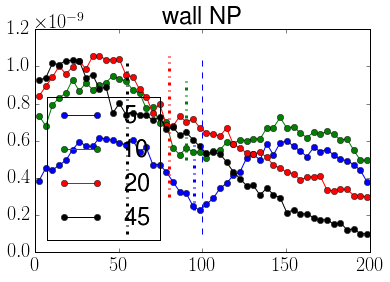

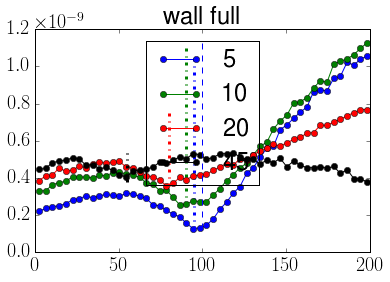

In [121]:
plot_dose_on_wall(names[:,1][[1,2,4,9]])
plot_dose_on_wall(names[:,0][[1,2,4,9]])
plot_full_dose_on_wall(names[[1,2,4,9]])

In [125]:
def full_flow_on_the_plate(names) :
    title = 'integral flow on plate mode = full'
    colors = Colors_generator()
    fig = plt.figure(figsize=FIGURES_SIZE)
    
    #outt = open("images\\" + title + ".csv", 'w')
    #outt.write("samlpe_length,z,value,dispersion\n")
    ys = []
    for ind in range(len(names)):
        neutron_file, photon_file = names[ind]
        name = os.path.split(neutron_file)[1]
        if os.path.split(neutron_file)[1][1:] != os.path.split(photon_file)[1][1:]:
            print "files_not_correspond_to_each_other"
            return
        tallies_n, tallies_p = obr.construct_tallies(neutron_file), obr.construct_tallies(photon_file)
        
        if len(name) == 4:
            sample_length = int(name[2:3])
        else:
            sample_length = int(name[2:4])
        
        x = []
        y = []
        dy = []
        
        for tally_ind in range(len(tallies_n)):
            if tallies_n[tally_ind].y == -100 + 1.5:
                if tallies_p[tally_ind].y != -100 + 1.5:
                    print "wong tellies order"
                    return
                x.append(tallies_n[tally_ind].z)
                y_n, dy_n = tallies_n[tally_ind].get_value_from_diaposon(0.1)
                y_p, dy_p = tallies_p[tally_ind].get_value_from_diaposon(0.1)
                y_p, dy_p = y_p/4, dy_p
                y.append(y_n + y_p)
                dy.append(y_n*dy_n + y_p*dy_p)
                #outt.write(str(sample_length) + ',' + str(x[-1]) + ',' + str(y[-1]) + ',' + str(dy[-1]) + '\n')
                
        ys.append(y)
        plt.errorbar(x, y, color=colors.get_next(), yerr=dy, label=( "sample length = " + str(sample_length) + 'sm.'), fmt='o')
        plt.xlabel(r'z, cm')
        plt.ylabel(r'particles, $\bf \frac{F}{cm^2 sec}$')
        plt.plot([100 - sample_length,100 - sample_length],[np.min(y),np.max(y)], '-.',c=colors.current(), linewidth=3)
        #plt.plot(mid, y, 'r--')
        #plt.savefig("images\\" + title + ".png", dpi = 300)
        #plt.show()
        #plt.close()
    
    #x=[i for i in range(60,100)]
    #y=[8*10**(-6) for i in range(60,100)]
    #plt.plot(x,y, color='black', linewidth=20, label='sample')
    
    #outt.close()
    plt.plot([100,100],[np.min(ys),np.max(ys)], '--', c='blue')
    
    plt.legend(fontsize=10, loc='best', prop={'size':LEGENDS_SIZE})
    plt.yscale('log')
    plt.title(title)
    #plt.ylim(ymin=5*10**(-10), ymax=2*10**(-8))
    plt.grid()
    #plt.savefig("images\\" + title + ".png", dpi = 300)
    plt.gcf().subplots_adjust(bottom=0.2, top=0.8, left=0.2)
    plt.savefig(pjoin(FOLDER_TO_SAVE_IMAGES, title.replace(' ','_') + '.png'), dpi = 600)
    plt.show()
    plt.close()

def PP_flow_on_the_plate(names) :
    title = 'integral flow on plate mode = PP'
    colors = Colors_generator()
    fig = plt.figure(figsize=FIGURES_SIZE)
    
    #outt = open("images\\" + title + ".csv", 'w')
    #outt.write("samlpe_length,z,value,dispersion\n")
    ys = []
    for ind in range(len(names)):
        photon_file = names[ind]
        name = os.path.split(names[ind])[1]
        tallies_p = obr.construct_tallies(photon_file)
        
        if len(name) == 4:
            sample_length = int(name[2:3])
        else:
            sample_length = int(name[2:4])
        
        x = []
        y = []
        dy = []
        
        for tally_ind in range(len(tallies_p)):
            if tallies_p[tally_ind].y == -100 + 1.5:
                x.append(tallies_p[tally_ind].z)
                y_p, dy_p = tallies_p[tally_ind].get_value_from_diaposon(0.1)
                y_p, dy_p = y_p/4, dy_p
                y.append(y_p)
                dy.append(y_p*dy_p)
                #outt.write(str(sample_length) + ',' + str(x[-1]) + ',' + str(y[-1]) + ',' + str(dy[-1]) + '\n')
                
        ys.append(y)
        plt.errorbar(x, y, color=colors.get_next(), yerr=dy, label=( "sample length = " + str(sample_length) + 'sm.'), fmt='o')
        plt.xlabel(r'z, cm')
        plt.ylabel(r'particles, $\bf \frac{F}{cm^2 sec}$')
        plt.plot([100 - sample_length,100 - sample_length],[np.min(y),np.max(y)], '-.',c=colors.current(), linewidth=3)
        
        #plt.plot(mid, y, 'r--')
        #plt.savefig("images\\" + title + ".png", dpi = 300)
        #plt.show()
        #plt.close()
    
    #x=[i for i in range(60,100)]
    #y=[8*10**(-6) for i in range(60,100)]
    #plt.plot(x,y, color='black', linewidth=20, label='sample')
    
    #outt.close()
    plt.plot([100,100],[np.min(ys),np.max(ys)], '--', c='blue')
    
    plt.legend(fontsize=10, loc='best', prop={'size':LEGENDS_SIZE})
    plt.yscale('log')
    plt.title(title)
    #plt.ylim(ymin=5*10**(-10), ymax=2*10**(-8))
    plt.grid()
    #plt.savefig("images\\" + title + ".png", dpi = 300)
    plt.gcf().subplots_adjust(bottom=0.2, top=0.8, left=0.2)
    plt.savefig(pjoin(FOLDER_TO_SAVE_IMAGES, title.replace(' ','_') + '.png'), dpi = 600)
    plt.show()
    plt.close()
    
def NP_flow_on_the_plate(names) :
    title = 'integral flow on plate mode = NP'
    colors = Colors_generator()
    fig = plt.figure(figsize=FIGURES_SIZE)
    
    #outt = open("images\\" + title + ".csv", 'w')
    #outt.write("samlpe_length,z,value,dispersion\n")
    ys = []
    for ind in range(len(names)):
        neutron_file = names[ind]
        name = os.path.split(names[ind])[1]
        tallies_n = obr.construct_tallies(neutron_file)
        
        if len(name) == 4:
            sample_length = int(name[2:3])
        else:
            sample_length = int(name[2:4])
        
        x = []
        y = []
        dy = []
        
        for tally_ind in range(len(tallies_n)):
            if tallies_n[tally_ind].y == -100 + 1.5:
                x.append(tallies_n[tally_ind].z)
                y_n, dy_n = tallies_n[tally_ind].get_value_from_diaposon(0.1)
                y.append(y_n)
                dy.append(y_n*dy_n)
                #outt.write(str(sample_length) + ',' + str(x[-1]) + ',' + str(y[-1]) + ',' + str(dy[-1]) + '\n')
                
        ys.append(y)
        plt.errorbar(x, y, color=colors.get_next(), yerr=dy, label=( r"sample length = " + str(sample_length) + r'sm.'), fmt='o')
        plt.xlabel(r'z, cm')
        plt.ylabel(r'particles, $\bf \frac{F}{cm^2 sec}$')
        plt.plot([100 - sample_length,100 - sample_length],[np.min(y),np.max(y)], '-.',c=colors.current(), linewidth=3)
        
        #plt.plot(mid, y, 'r--')
        #plt.savefig("images\\" + title + ".png", dpi = 300)
        #plt.show()
        #plt.close()
    
    #x=[i for i in range(60,100)]
    #y=[8*10**(-6) for i in range(60,100)]
    #plt.plot(x,y, color='black', linewidth=20, label='sample')
    
    #outt.close()
    plt.plot([100,100],[np.min(ys),np.max(ys)], '--', c='blue')
    
    plt.legend(fontsize=10, loc='best', prop={'size':LEGENDS_SIZE})
    plt.yscale('log')
    plt.title(title)
    #plt.ylim(ymin=5*10**(-10), ymax=2*10**(-8))
    plt.grid()
    #plt.savefig("images\\" + title + ".png", dpi = 300)
    plt.gcf().subplots_adjust(bottom=0.2, top=0.8, left=0.2)
    plt.savefig(pjoin(FOLDER_TO_SAVE_IMAGES, title.replace(' ','_') + '.png'), dpi = 600)
    plt.show()
    plt.close()

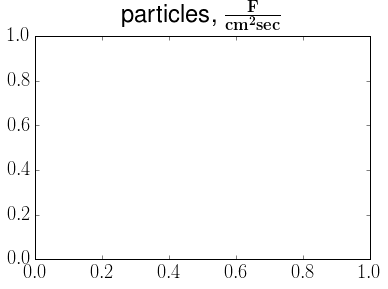

In [126]:

plt.title(r'particles, $\bf \frac{F}{cm^2 sec}$')

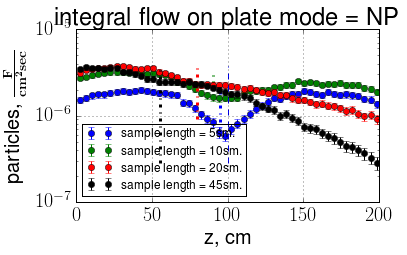

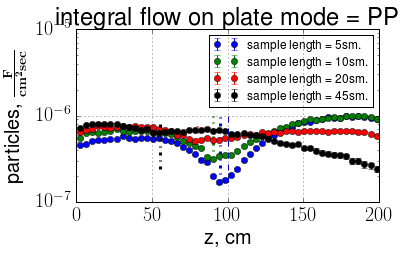

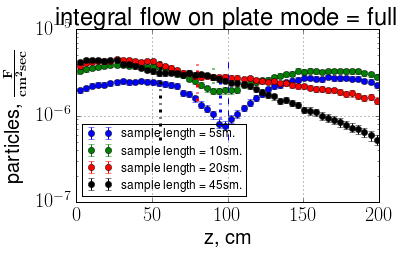

In [127]:
NP_flow_on_the_plate((names[1][0], names[2][0], names[4][0], names[9][0]))
PP_flow_on_the_plate((names[1][1], names[2][1], names[4][1], names[9][1]))
full_flow_on_the_plate((names[1], names[2], names[4], names[9]))

In [17]:
(names[0], names[3], names[6], names[9])

(array(['mcnp_out_medial\\NP0a', 'mcnp_out_medial\\PP0a'], 
       dtype='|S21'),
 array(['mcnp_out_medial\\NP15a', 'mcnp_out_medial\\PP15a'], 
       dtype='|S21'),
 array(['mcnp_out_medial\\NP30a', 'mcnp_out_medial\\PP30a'], 
       dtype='|S21'),
 array(['mcnp_out_medial\\NP45a', 'mcnp_out_medial\\PP45a'], 
       dtype='|S21'))

In [19]:
# full flow on the plate tails

def full_flow_on_the_plate(names, colores, E_cut_off=0) :
    title = 'integral flow on plate. mode = full'
    #outt = open("images\\" + title + ".csv", 'w')
    #outt.write("samlpe_length,z,value,dispersion\n")
    for ind in range(len(names)):
        neutron_file, photon_file = names[ind]
        name = os.path.split(neutron_file)[1]
        col = colores[ind]
        if os.path.split(neutron_file)[1][1:] != os.path.split(photon_file)[1][1:]:
            print "files_not_correspond_to_each_other"
            return
        tallies_n, tallies_p = obr.construct_tallies(neutron_file), obr.construct_tallies(photon_file)
        
        if len(name) == 4:
            sample_length = int(name[2:3])
        else:
            sample_length = int(name[2:4])
        
        x = []
        y = []
        dy = []
        
        for tally_ind in range(len(tallies_n)):
            if tallies_n[tally_ind].y == -100 + 1.5:
                if tallies_p[tally_ind].y != -100 + 1.5:
                    print "wong tellies order"
                    return
                x.append(tallies_n[tally_ind].z)
                y_n, dy_n = tallies_n[tally_ind].get_value_from_diaposon(E_cut_off)
                y_p, dy_p = tallies_p[tally_ind].get_value_from_diaposon(E_cut_off)
                y_p, dy_p = y_p/4, dy_p
                y.append(y_n + y_p)
                dy.append(y_n*dy_n + y_p*dy_p)
                #outt.write(str(sample_length) + ',' + str(x[-1]) + ',' + str(y[-1]) + ',' + str(dy[-1]) + '\n')
                
        plt.errorbar(x, y, color=col, yerr=dy, label=( "sample length = " + str(sample_length) + 'sm.'), fmt='o')
        plt.title(r'plate.integral.\\sample len = ' + str(sample_length) + r'cm. mode = full')
        plt.xlabel(r'z, cm')
        plt.ylabel(r'particles, $\frac{F}{cm^2 sec}$')
        #plt.plot(mid, y, 'r--')
        #plt.savefig("images\\" + title + ".png", dpi = 300)
        #plt.show()
        #plt.close()
    
    #x=[i for i in range(60,100)]
    #y=[8*10**(-6) for i in range(60,100)]
    #plt.plot(x,y, color='black', linewidth=20, label='sample')
    
    #outt.close()
    plt.legend(fontsize=10, loc='best')
    plt.yscale('log')
    #plt.ylim(ymin=5*10**(-10), ymax=2*10**(-8))
    plt.grid()
    #plt.savefig("images\\" + title + ".png", dpi = 300)
    plt.show()
    plt.close()

def PP_flow_on_the_plate(names, colores, E_cut_off=0) :
    title = 'integral flow on plate. mode = PP'
    #outt = open("images\\" + title + ".csv", 'w')
    #outt.write("samlpe_length,z,value,dispersion\n")
    for ind in range(len(names)):
        photon_file = names[ind]
        name = os.path.split(names[ind])[1]
        col = colores[ind]
        tallies_p = obr.construct_tallies(photon_file)
        
        if len(name) == 4:
            sample_length = int(name[2:3])
        else:
            sample_length = int(name[2:4])
        
        x = []
        y = []
        dy = []
        
        for tally_ind in range(len(tallies_p)):
            if tallies_p[tally_ind].y == -100 + 1.5:
                x.append(tallies_p[tally_ind].z)
                y_p, dy_p = tallies_p[tally_ind].get_value_from_diaposon(E_cut_off)
                y_p, dy_p = y_p/4, dy_p
                y.append(y_p)
                dy.append(y_p*dy_p)
                #outt.write(str(sample_length) + ',' + str(x[-1]) + ',' + str(y[-1]) + ',' + str(dy[-1]) + '\n')
                
        plt.errorbar(x, y, color=col, yerr=dy, label=( "sample length = " + str(sample_length) + 'sm.'), fmt='o')
        plt.title(r'plate.integral.\\sample len = ' + str(sample_length) + r'cm. mode = PP')
        plt.xlabel(r'z, cm')
        plt.ylabel(r'particles, $\frac{F}{cm^2 sec}$')
        #plt.plot(mid, y, 'r--')
        #plt.savefig("images\\" + title + ".png", dpi = 300)
        #plt.show()
        #plt.close()
    
    #x=[i for i in range(60,100)]
    #y=[8*10**(-6) for i in range(60,100)]
    #plt.plot(x,y, color='black', linewidth=20, label='sample')
    
    #outt.close()
    plt.legend(fontsize=10, loc='best')
    plt.yscale('log')
    #plt.ylim(ymin=5*10**(-10), ymax=2*10**(-8))
    plt.grid()
    #plt.savefig("images\\" + title + ".png", dpi = 300)
    plt.show()
    plt.close()
    
def NP_flow_on_the_plate(names, colores, E_cut_off=0) :
    title = 'integral flow on plate. mode = NP'
    #outt = open("images\\" + title + ".csv", 'w')
    #outt.write("samlpe_length,z,value,dispersion\n")
    for ind in range(len(names)):
        neutron_file = names[ind]
        name = os.path.split(names[ind])[1]
        col = colores[ind]
        tallies_n = obr.construct_tallies(neutron_file)
        
        if len(name) == 4:
            sample_length = int(name[2:3])
        else:
            sample_length = int(name[2:4])
        
        x = []
        y = []
        dy = []
        
        for tally_ind in range(len(tallies_n)):
            if tallies_n[tally_ind].y == -100 + 1.5:
                x.append(tallies_n[tally_ind].z)
                y_n, dy_n = tallies_n[tally_ind].get_value_from_diaposon(E_cut_off)
                y.append(y_n)
                dy.append(y_n*dy_n)
                #outt.write(str(sample_length) + ',' + str(x[-1]) + ',' + str(y[-1]) + ',' + str(dy[-1]) + '\n')
                
        plt.errorbar(x, y, color=col, yerr=dy, label=( "sample length = " + str(sample_length) + 'sm.'), fmt='o')
        plt.title(r'plate.integral.\\sample len = ' + str(sample_length) + r'cm. mode = NP')
        plt.xlabel(r'z, cm')
        plt.ylabel(r'particles, $\frac{F}{cm^2 sec}$')
        #plt.plot(mid, y, 'r--')
        #plt.savefig("images\\" + title + ".png", dpi = 300)
        #plt.show()
        #plt.close()
    
    #x=[i for i in range(60,100)]
    #y=[8*10**(-6) for i in range(60,100)]
    #plt.plot(x,y, color='black', linewidth=20, label='sample')
    
    #outt.close()
    plt.legend(fontsize=10, loc='best')
    plt.yscale('log')
    #plt.ylim(ymin=5*10**(-10), ymax=2*10**(-8))
    plt.grid()
    #plt.savefig("images\\" + title + ".png", dpi = 300)
    plt.show()
    plt.close()

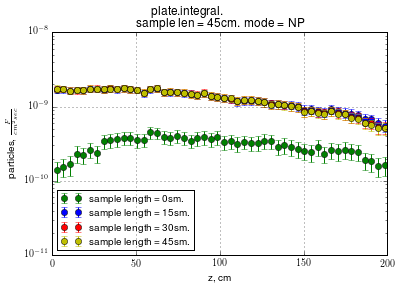

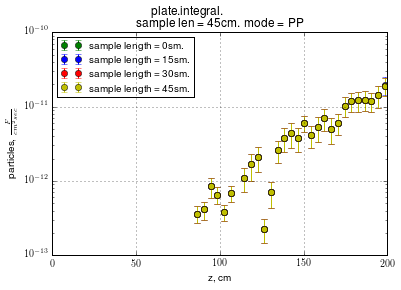

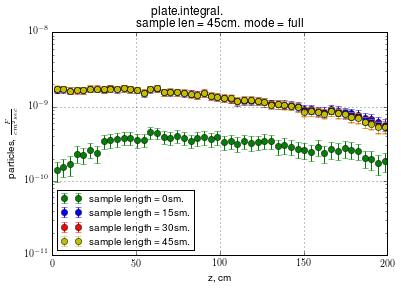

In [23]:
E_cut_off = 2.5
NP_flow_on_the_plate((names[0][0], names[3][0], names[6][0], names[9][0]), ['green','blue','red','y'], E_cut_off)
PP_flow_on_the_plate((names[0][1], names[3][1], names[6][1], names[9][1]), ['green','blue','red','y'], E_cut_off)
full_flow_on_the_plate((names[0], names[3], names[6], names[9]), ['green','blue','red','y'], E_cut_off)

In [7]:
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import clear_output

def all_doses(file_, e, a):
    fig = plt.figure(figsize=(10,12))
    ax = fig.add_subplot(111, projection='3d')
    name = os.path.split(file_)[1]
    tallies = obr.construct_tallies(file_)
    x=[]
    y=[]
    z=[]
    doses = []
    mode = name[:2]
    if mode=='PP':
        etalon_tallies = obr.construct_tallies(pjoin(SOURCES_FOLDER,'PP0a'))
    for i in range(len(tallies)):
        x.append(tallies[i].x)
        z.append(tallies[i].z)
        y.append(tallies[i].y)
        if mode=='PP':
            if tallies[i].z < 100 and abs(tallies[i].y) < 18:
                doses.append((tallies[i].get_dose()[0] - etalon_tallies[i].get_dose()[0])/4.)
            else:
                doses.append((tallies[i].get_dose()[0])/4.)
        else:
            doses.append(tallies[i].get_dose()[0])
    doses_n = doses/np.max(doses)
    #doses_n = doses_n
    z = np.array(z)
    sct = ax.scatter(x,y,z,c=doses_n,s=100*doses_n, cmap='jet')
    colbar = fig.colorbar(sct)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_xlim3d(-100, 100)
    ax.set_ylim3d(-100, 100)
    ax.set_zlim3d(0, 200)
    ax.set_title(mode + '  ' + name[2:-1])
    
    ax.azim = a
    ax.elev = e
    return fig

def all_doses_full(file_p, file_n, e, a):
    fig = plt.figure(figsize=(10,12))
    ax = fig.add_subplot(111, projection='3d')
    tallies_p = obr.construct_tallies(file_p)
    tallies_n = obr.construct_tallies(file_n)
    x=[]
    y=[]
    z=[]
    doses = []
    etalon_tallies = obr.construct_tallies(pjoin(SOURCES_FOLDER,'PP0a'))
    for i in range(len(tallies_p)):
        x.append(tallies_p[i].x)
        z.append(tallies_p[i].z)
        y.append(tallies_p[i].y)
        if tallies_p[i].z < 100 and abs(tallies_p[i].y) < 18:
            doses.append(tallies_n[i].get_dose()[0] + (tallies_p[i].get_dose()[0] - etalon_tallies[i].get_dose()[0])/4.)
        else:
            doses.append(tallies_n[i].get_dose()[0] + tallies_p[i].get_dose()[0]/4.)
    doses_n = doses/np.max(doses)
    #doses_n = doses_n
    z = np.array(z)
    sct = ax.scatter(x,y,z,c=doses_n,s=100*doses_n, cmap='jet')
    colbar = fig.colorbar(sct)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_xlim3d(-100, 100)
    ax.set_ylim3d(-100, 100)
    ax.set_zlim3d(0, 200)
    #ax.set_title("full" + '  ' + [2:-1])
    
    ax.azim = a
    ax.elev = e
    return fig

In [8]:
verify_folder_existence('__video')
counter = 0
for e in range(-30,61,30):
    for a in range(0,360,3):
        name = str(counter).rjust(5,'0')+'.png'
        print '\r', name,
        fig = all_doses_full(pjoin(SOURCES_FOLDER,"PP50a"),pjoin(SOURCES_FOLDER,"NP50a"), e=e, a=a)
        #plt.show()
        fig.savefig('__video/'+name)
        counter += 1
        fig.clear()
        clear_output(wait=True)